# An Investigation of Linear Concept Approximation

This Notebook is a part of the Thesis Project: Learning Multilingual Document Representations.
(Marc Lenz, 2021)


** **

##  1. Load Preprocessed Dataset

The original JRC-Arquis dataset have been preprocessed before. 
The aligned documents have been saved in two seperate csv files. 
For details of the preprocessing, check: read_and_preprocess.py

In [1]:
from Utils import read_docs
from sklearn.model_selection import train_test_split

# parse an xml file by name
french_docs, english_docs = read_docs('Data/jrq_aligned_10000_fr.csv', 'Data/jrq_aligned_10000_en.csv')
fr_docs_train, fr_docs_test, en_docs_train, en_docs_test = train_test_split(french_docs, english_docs, 
                                                                            test_size=0.1, random_state = 42)

print("Number of training Documents: "+ str(len(fr_docs_train)))
print("Number of test Documents: "+ str(len(fr_docs_test)))

Number of training Documents: 8759
Number of test Documents: 974


## 2.Training of Linear Concept Approximation
- Train LSI for different sample sizes and dimensions


In [2]:
from Utils import dict_combinations
from Utils import Vector_Lsi_Model, LCA_Model
import random 

sample_sizes = [1000, 2000, 4000, 8000]
dimensions = [50, 200, 500, 800]

#Creates List of Parameter Dictonaries
lsi_model_params = dict_combinations({"sample_size": sample_sizes, 
                                      "dimension" : dimensions})

#Train LSI Models with the given parameter list
lca_models = []
for param in lsi_model_params:
    
    #Get random sample
    sample_size = param["sample_size"]
    training_docs = list(zip(en_docs_train, fr_docs_train))
    random.shuffle(training_docs)
    en_docs_train_shuffled, fr_docs_train_shuffled = zip(*training_docs)
    sample_en = en_docs_train_shuffled[:sample_size]
    sample_fr = fr_docs_train_shuffled[:sample_size]
    
    #Now train models
    lsi_model_en = Vector_Lsi_Model(sample_en, dimension = param["dimension"])
    lsi_model_fr = Vector_Lsi_Model(sample_fr, dimension = param["dimension"])
    lca = LCA_Model(sample_en, sample_fr, lsi_model_en, lsi_model_fr)
    lca_models.append(lca)

## Evaluation
- Train LSI for different sample sizes and dimensions

In [3]:
from Utils import mate_retrieval_score

scores = []
for lca_model in lca_models:
    env = lca_model.create_embeddings(en_docs_test, language= "l1")
    frv = lca_model.create_embeddings(fr_docs_test, language= "l2")
    score = mate_retrieval_score(env, frv)
    scores.append(score)

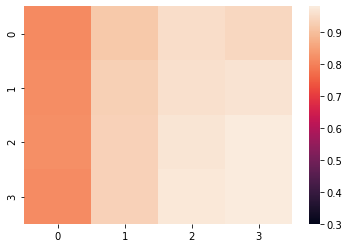

In [4]:
import numpy as np
import seaborn as sns


score_matrix = np.asarray(scores).reshape(len(sample_sizes),len(dimensions))
ax = sns.heatmap(score_matrix, vmin=0.3)

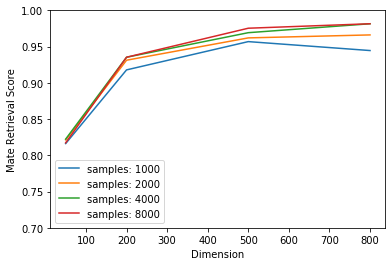

In [5]:
import matplotlib.pyplot as plt

for k in range(len(sample_sizes)):
    plt.plot(dimensions,score_matrix[k], label="samples: "+str(sample_sizes[k]))
plt.xlabel("Dimension")
plt.ylabel("Mate Retrieval Score")
plt.ylim((0.7,1))
plt.legend()

sdlkfjdlsjf